In [1]:
!pip install scikit-learn keras-tuner git+https://github.com/paulgavrikov/visualkeras.git pydot pydotplus tf-nightly
!apt install graphviz xxd --assume-yes
!python --version

  Cloning https://github.com/paulgavrikov/visualkeras.git to /tmp/pip-req-build-9dnoi8uv
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras.git /tmp/pip-req-build-9dnoi8uv
  Resolved https://github.com/paulgavrikov/visualkeras.git to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
xxd is already the newest version (2:8.1.2269-1ubuntu5.14).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Python 3.8.10


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras_tuner
import tensorflow as tf
import keras

from keras import layers
from keras.utils import timeseries_dataset_from_array, to_categorical
import visualkeras
from PIL import ImageFont
import logging
from enum import Enum
import itertools
import os
import pickle
import re
import random
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from utils import load_gesture_samples, GestureNames, split_data_between_participants, normalize_dataset

2023-05-26 19:16:12.109722: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 19:16:12.312327: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-05-26 19:16:12.312353: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-05-26 19:16:12.312889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-26 19:16:12.405412: I tensorflow/core/platform/cpu_feature_g

In [104]:
!nvidia-smi

Tue May 23 10:11:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 50%   56C    P3    51W / 290W |   7358MiB /  8192MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
print(tf.__version__)

print('1: ', tf.config.list_logical_devices())
print('2: ', tf.test.is_built_with_cuda())
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.14.0-dev20230524
1:  [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2:  True
3:  /device:GPU:0
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


2023-05-24 17:22:53.479746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 17:22:53.500205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 17:22:53.500383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 17:22:53.502612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 17:22:53.502757: I tensorflow/compile

In [2]:
# Setup logger
logging.basicConfig(level=logging.DEBUG,
                    force = True)

log = logging.getLogger("CSE3000")
log.setLevel(logging.INFO)

In [3]:
# Utility functions cell
RANDOM_SEED = 1000


np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


class Hand(Enum):
    right = "right_hand"
    left = "left_hand"


class GestureException(Exception):
    pass


class Gestures(Enum):
    SWIPE_LEFT = 0, 'swipe_left'
    SWIPE_RIGHT = 1, 'swipe_right'
    SWIPE_UP = 2, 'swipe_up'
    SWIPE_DOWN = 3, 'swipe_down'
    ROT_CW = 4, 'clockwise'
    ROT_CCW = 5, 'counter_clockwise'
    TAP = 6, 'tap'
    DOUBLE_TAP = 7, 'double_tap'
    ZOOM_IN = 8, 'zoom_in'
    ZOOM_OUT = 9, 'zoom_out'

    def __new__(cls, value, name):
        member = object.__new__(cls)
        member._value_ = value
        member.fullname = name
        return member

    def __int__(self):
        return self.value

    def __str__(self):
        return self.fullname

    @staticmethod
    def from_name(name: str):
        try:
            return next(g for g in Gestures if g.fullname == name)
        except StopIteration:
            raise GestureException("No gesture with name '%s' found..." % name)


class LoadGestureException(Exception):
    pass


def load_gesture_samples(gesture: Gestures, hand: Hand = Hand.right, skip_old_data: bool = True):
    result = []
    base_path = f"gestures_data/gestures/{gesture.fullname}/{hand.value}"
    log.debug("Loading gestures from base path: %s" % base_path)
    folder_items = os.listdir(base_path)

    # Filter on the .pickle extension
    filtered_ext = list(filter(lambda x: re.search(r'\.pickle$', x) is not None, folder_items))

    if len(filtered_ext) == 0:
        raise LoadGestureException("No gestures found in folder: %s" % base_path)

    for item in filtered_ext:
        r_match = re.match(r'candidate_(\w+).pickle$', item)
        if r_match is None:
            raise LoadGestureException("Incorrectly formatted data file name: %s" % item)

        candidate_id = r_match.group(1)
        with open(os.path.join(base_path, item), 'rb') as f:
            while True:
                try:
                    data_contents = pickle.load(f)

                    if isinstance(data_contents, dict):
                        if 'target_gesture' in data_contents:
                            # Data v3
                            # print(data_contents)
                            data_contents['gesture'] = Gestures.from_name(data_contents['target_gesture'])
                            # data_contents['all_data'] = data_contents['data']
                            # print(type(data_contents['data']))
                            # data_contents['data'] = list(map(lambda x: x['data'], data_contents['data']))
                            result.append(data_contents)
                        else:
                            # Data v2
                            data_contents['gesture'] = Gestures.from_name(data_contents['gesture'])
                            if not skip_old_data:
                                result.append(data_contents)
                    else:
                        # Data loader v1
                        data = {
                            'data': data_contents,
                            'gesture': gesture,
                            'candidate': candidate_id
                        }
                        if not skip_old_data:
                            result.append(data)
                except EOFError:
                    break

    return result


def split_data_between_participants(data, ratio = 0.7, expected_input_shape = (100, 3), dtype = np.int16):
    lb_candidate = lambda x: x['candidate']

    # For itertools.groupby to work we need to sort the data first
    data.sort(key=lambda x: x['candidate'])

    participants = set(map(lb_candidate, data))
    amount_measurements = len(data)
    amount_participants = len(participants)

    log.debug("Participants: %s" % participants)
    log.info("Got dataset for %d participants with %d measurements total" % (amount_participants, amount_measurements))

    amount_train = int(amount_measurements * ratio)
    amount_test = amount_measurements - amount_train
    log.info("Estimating %d measurements for training and %d measurements for test (ratio: %0.1f)" % (amount_train, amount_test, ratio))

    train_data = []
    train_data_outcomes = []

    test_data = []
    test_data_outcomes = []

    train_candidates = set()
    test_candidates = set()

    # Group the data per participant as that is the recommended method for training models
    for participant, d in itertools.groupby(data, lb_candidate):
        d_list = list(d)

        # if participant == 'A3':
        #     continue

        for data_point in d_list:
            try:
                if len(train_data) < amount_train:
                    assert data_point['data'].shape == expected_input_shape
                    train_candidates.add(participant)
                    train_data.append(data_point['data'])
                    train_data_outcomes.append(data_point['gesture'])
                else:
                    test_candidates.add(participant)
                    test_data.append(data_point['data'])
                    test_data_outcomes.append(data_point['gesture'])
                    # test_data.extend([p['data'] for p in d_list])
                    # test_data_outcomes.extend([p['gesture'].value for p in d_list])
            except AssertionError as e:
                log.error("Could not load gesture %s of participant %s (expected shape: %s but got %s)" % (data_point['gesture'], participant, expected_input_shape, data_point['data'].shape))

    log.info("Train candidates: %s\tTest candidates: %s" % (train_candidates, test_candidates))

    return (np.array(train_data, dtype=dtype), np.array(train_data_outcomes, dtype=dtype)), (np.array(test_data, dtype=dtype), np.array(test_data_outcomes, dtype=dtype))

def normalize_dataset(data, dtype = np.float32):
    """Watch out this function might not normalize the data as expected, further research required"""
    normalized = []
    for graph in data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        reshaped = scaler.fit_transform(graph.reshape(-1, graph.shape[-1])).reshape(graph.shape)
        normalized.append(reshaped)
    return np.array(normalized, dtype=dtype)

def normalize_test(data):
    normalized = []
    for measurement in data:
        mean = measurement.mean()
        std = measurement.std()
        normalized_measurement = (measurement - mean) / std

        normalized.append(normalized_measurement)
    return normalized

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    mae = history.history['mae']
    val_mae = history.history['val_mae']

    epochs = range(1, len(loss) + 1)

    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    axs[0].plot(epochs, loss, 'g.', label='Training Loss')
    axs[0].plot(epochs, val_loss, 'c.', label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, mae, 'g.', label='Training MAE')
    axs[1].plot(epochs, val_mae, 'c.', label='Validation MAE')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MAE')
    axs[1].legend()

    axs[2].plot(epochs, acc, 'g.', label='Training Accuracy')
    axs[2].plot(epochs, val_acc, 'c.', label='Validation Accuracy')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Accuracy')
    axs[2].legend()

    fig.savefig('output_figures/history_plot.svg')
    fig.show()

def compile_model(model: keras.Model):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

def kfold_cross_validation(model: keras.Model, features: np.ndarray, labels: np.ndarray, num_folds: int = 5):
    kfold = KFold(num_folds, shuffle=True, random_state=RANDOM_SEED)

    fold_num = 1
    acc_per_fold = []
    loss_per_fold = []
    confusion_per_fold = []

    for train, test in kfold.split(features, labels):
        fold_model = keras.models.clone_model(model)
        log.info("Fold No. %d" % fold_num)
        compile_model(fold_model)
        history = fold_model.fit(features[train], labels[train], batch_size=32, epochs=200, verbose=2)
        scores = fold_model.evaluate(features[test], labels[test], verbose=2)
        predictions = np.argmax(fold_model.predict(features[test]), axis=1)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        # confusion_per_fold.append(confusion_matrix(labels[test], predictions))

        fold_num += 1



    return acc_per_fold, loss_per_fold, confusion_per_fold


In [4]:
combined = []

# skip_gestures = [Gestures.ZOOM_IN, Gestures.ZOOM_OUT, Gestures.DOUBLE_TAP, Gestures.ROT_CW, Gestures.ROT_CCW]
skip_gestures = []
# only_gestures = [Gestures.SWIPE_UP, Gestures.SWIPE_DOWN, Gestures.SWIPE_RIGHT, Gestures.SWIPE_LEFT, Gestures.TAP]
filtered_gestures = filter(lambda x: x not in skip_gestures, Gestures)
filtered_gestures_list = list(filtered_gestures)

right_samples_count = 0
left_samples_count = 0
for g in filtered_gestures_list:
    right_samples = load_gesture_samples(g, hand=Hand.right)
    left_samples = load_gesture_samples(g, hand=Hand.left)
    right_samples_count += len(right_samples)
    left_samples_count += len(left_samples)
    combined.extend(right_samples)
    combined.extend(left_samples)

log.info("Got %d Right hand measurements and %d Left hand measurements" % (right_samples_count, left_samples_count))

# Deterministic shuffle
random.Random(4).shuffle(combined)

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
(x_train, y_train), (x_test, y_test) = split_data_between_participants(combined, 0.7)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

x_train_normalized = normalize_dataset(x_train)
x_test_normalized = normalize_dataset(x_test)

y_train = to_categorical(y_train, len(Gestures))
y_test = to_categorical(y_test, len(Gestures))

# Hardcoded for now, so fix
# x_train_normalized = x_train_normalized.reshape((-1, 100, 3, 1))
# x_test_normalized = x_test_normalized.reshape((-1, 100, 3, 1))

# For CNN
input_shape = (25, 4, 3)
x_train_cnn = x_train_normalized.reshape((-1, 25, 4, 3))
x_test_cnn = x_test_normalized.reshape((-1, 25, 4, 3))

# For RNN
rnn_shape = [20, 15]
x_train_rnn = x_train_normalized.reshape([-1] + rnn_shape)
x_test_rnn = x_test_normalized.reshape([-1] + rnn_shape)

print(x_train_normalized.shape)
print(x_test_normalized.shape)

# Combine for K-Fold
combined_x = np.concatenate([x_train_normalized, x_test_normalized])
combined_y = np.concatenate([y_train, y_test])

print(combined_x.shape)
print(combined_y.shape)


INFO:CSE3000:Got 742 Right hand measurements and 489 Left hand measurements
INFO:CSE3000:Got dataset for 19 participants with 1231 measurements total
INFO:CSE3000:Estimating 861 measurements for training and 370 measurements for test (ratio: 0.7)
ERROR:CSE3000:Could not load gesture zoom_in of participant A3 (expected shape: (100, 3) but got (350, 3))
INFO:CSE3000:Train candidates: {'A1', 'Arne', 'C2', 'C6', 'E1', 'C1', 'A3', 'C4', 'E2', 'C5', 'E3', 'C3', 'E0', 'C8'}	Test candidates: {'sem_15052023', 'E6', 'E5', 'E4', 'default', 'E3'}


(861, 100, 3)
(861,)
(369, 100, 3)
(369,)
(861, 100, 3)
(369, 100, 3)
(1230, 100, 3)
(1230, 10)


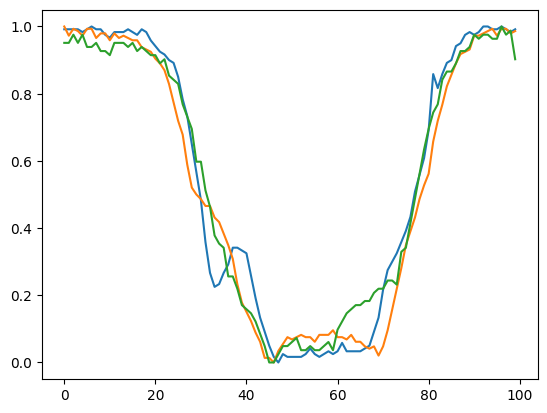

In [40]:
# Visualisation for CNN
one_sample = x_train_normalized[200]
plt.plot(one_sample)
plt.savefig('output_figures/sample_graph.svg')
plt.show()

(100, 3)
(3, 100)


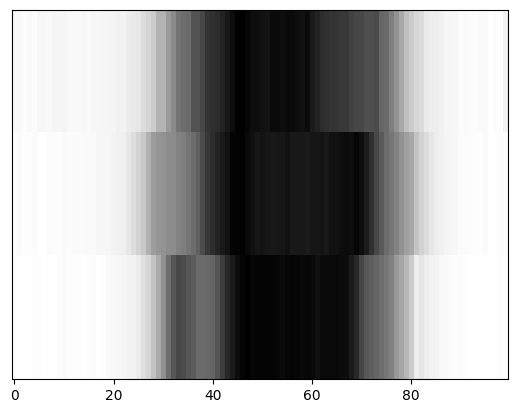

In [41]:
# reshaped_sample = one_sample.reshape((100, 3))
reshaped_sample = np.rot90(one_sample, k=1)
print(one_sample.shape)
print(reshaped_sample.shape)
# plt.plot(one_sample[:,0])
plt.imshow(1 - reshaped_sample, cmap='Greys', interpolation='nearest', aspect='auto')
plt.yticks([])
plt.savefig('output_figures/sample_heatmap.svg')
plt.show()

In [42]:
print(x_train_normalized[0][:,:,:1].shape)
one_sample = x_train_normalized[200]
image_data = np.concatenate([one_sample[:,:,0], one_sample[:,:,1], one_sample[:,:,2]], axis=1)
plt.imshow(1-image_data, cmap='Greys', aspect=1)
plt.savefig('output_figures/convolutional_sample.svg')
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

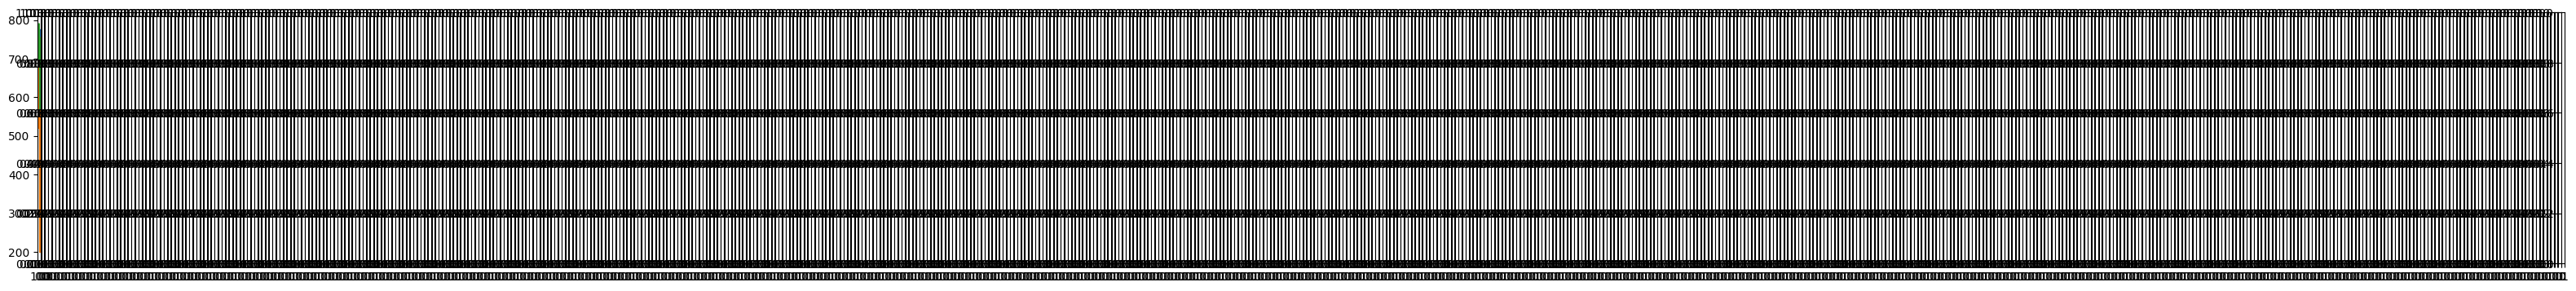

In [43]:
# Show all training data
train_amount = len(x_train)
fig, axs = plt.subplots(1, train_amount, figsize=(40, 4))
for i in range(train_amount):
    axs[i].plot(x_train[i])
    axs[i].annotate(Gestures(y_train[i]).fullname, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

In [ ]:
# Show all test data
test_amount = len(x_test)
fig, axs = plt.subplots(1, test_amount, figsize=(20, 4))
for i in range(test_amount):
    axs[i].plot(x_test[i])
    axs[i].annotate(f'Gesture: {Gestures(y_test[i]).fullname}', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

In [ ]:
# Show normalized test data
test_amount = len(x_test_normalized)
fig, axs = plt.subplots(1, test_amount, figsize=(20, 4))
for i in range(test_amount):
    axs[i].plot(x_test_normalized[i])

In [ ]:
# Implement data windowing
# SLICES = 5
#
# single_source = np.array(train[0], dtype=np.uint16)
# single_targets = np.full((single_source.shape[0], 1, 1), train_outcome[0])
# print(single_source.shape)
#
# train_ds = timeseries_dataset_from_array(data=single_source, targets=single_targets, sequence_length=SLICES, sequence_stride=SLICES)
#
# for example_inputs, example_labels in train_ds.take(1):
#     print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#     print(f'Targets shape (batch, time, features): {example_labels.shape}')
#
#
# single_validation_source = np.array(test[0], dtype=np.uint16)
# single_validation_targets = np.full((single_validation_source.shape[0], 1, 1), test_outcome[0])
#
# validation_ds = keras.utils.timeseries_dataset_from_array(data=single_validation_source, targets=single_validation_targets, sequence_length=SLICES, sequence_stride=SLICES)


In [ ]:
# train_ds = timeseries_dataset_from_array(data=x_train, targets=y_train, sequence_length=SLICES, sequence_stride=SLICES)
# validation_ds = timeseries_dataset_from_array(data=x_test, targets=y_test, sequence_length=SLICES, sequence_stride=SLICES)

In [ ]:
# print(dir(train_ds))
# print(train_ds.element_spec)

In [ ]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

def build_cnn_model(shape):
    model = keras.Sequential()

    # model_lstm.add(layers.LSTM(units=128, input_shape=[1, 3]))
    model.add(layers.Input(shape=shape, name="sensor_image"))
    model.add(layers.ZeroPadding2D(padding=(0, 2)))
    model.add(layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), activation="relu"))
    model.add(layers.Conv2D(16, kernel_size=(2, 2), strides=(1, 1), activation="relu"))
    model.add(layers.Conv2D(16, kernel_size=(2, 2), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(3, 1)))
    model.add(layers.Conv2D(32, kernel_size=(5, 1), activation="relu"))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))

    return model


In [ ]:
model_cnn = build_cnn_model(input_shape)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
model_cnn.summary()
start = time.perf_counter()
simple_history = model_cnn.fit(x_train_cnn, y_train, epochs=200, batch_size=2, validation_data=(x_test_cnn, y_test))

end = time.perf_counter()
print("Training took: %0.1f seconds" % (end - start))

# Training times:
| GPU   | CPU   |
|-------|-------|
| 18.5s | 12.3s |

In [ ]:
plot_history(simple_history)

In [ ]:
score = model_cnn.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
y_pred = model_cnn.predict(x_test_cnn)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='true', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix CNN")
plt.savefig('output_figures/confusion_matrix_cnn.svg', bbox_inches="tight")

plt.show()

In [ ]:
# K-Fold validation
model_cnn = build_cnn_model(input_shape)
(acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model_cnn, combined_x, combined_y, num_folds=5)

In [ ]:
print(acc_per_fold)
print(loss_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

In [ ]:
print(x_test_normalized.shape)

for i in range(x_test_normalized.shape[0]):
    test_sample = np.expand_dims(x_test_normalized[i], -4)
    test_prediction = model_cnn.predict(test_sample)
    print("Prediction: %s, actual: %s" % (Gestures(np.argmax(test_prediction)), Gestures(np.argmax(y_test[i]))))

In [ ]:
# Split data visualisation
print(x_train_normalized.shape)
SEQUENCE_LENGTH = 4

for measurement_x, measurement_y in zip(x_train_normalized, y_train):

    # Lock the measurement for now:
    measurement_x = x_train_normalized[200]
    measurement_y = y_train[200]
    print(measurement_x.shape)
    print(measurement_y.shape)
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(measurement_x)
    timeseries_train_ds = timeseries_dataset_from_array(measurement_x, measurement_y, sequence_length=SEQUENCE_LENGTH, shuffle=True)

    for inputs, targets in timeseries_train_ds:
        print(inputs.shape)
        print(targets.shape)

        print("Input length is: %d" % len(inputs))
        for i in range(len(inputs)):
            axs[1].plot(np.arange(SEQUENCE_LENGTH * i, SEQUENCE_LENGTH * (i + 1)), inputs[i])
            # axs[1].plot(inputs[i])
            # plt.plot(np.arange(10 * i, 10 * (i + 1)), np.arange(1, step=0.1))


    fig.show()
    break

In [ ]:
BATCH_SIZE = 10
SEQUENCE_LENGTH = 100

# Split video input visualisation
measurement_x = x_train_normalized[200]
measurement_y = y_train[200]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(measurement_x)

split_x = np.array(np.array_split(measurement_x, BATCH_SIZE))
for i in range(len(split_x)):
    axs[1].plot(np.arange((SEQUENCE_LENGTH/BATCH_SIZE) * i, (SEQUENCE_LENGTH/BATCH_SIZE) * (i + 1)), split_x[i])

print(split_x.shape)
fig.show()

In [5]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

def build_lstm_stateless_model(lstm_units, dense_1_units, dense_1, dropout, input_shape):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model = keras.Sequential(name="LSTM_Stateless")

    model.add(layers.Input(shape=input_shape, dtype=np.float32, name="sensor_image"))
    model.add(layers.LSTM(units=lstm_units, name="lstm", time_major=False, return_sequences=True))

    # Extra
    if dropout:
        model.add(layers.Dropout(rate=0.25, name="dropout"))

    # TODO: Try removing this dense layer
    if dense_1:
        model.add(layers.Dense(units=dense_1_units, activation='relu', name="dense_1"))

    model.add(layers.Flatten())

    # Output stage
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    model.summary()
    return model

def build_tuning_lstm_stateless_model(hp):
    lstm_units = hp.Choice('units', [32, 64, 128, 256, 512, 1024])
    dense_1_units = hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024])
    dropout = hp.Boolean("dropout")
    dense_1 = hp.Boolean("dense_1")
    model = build_lstm_stateless_model(lstm_units, dense_1_units, dense_1, dropout, input_shape=rnn_shape)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    return model


In [49]:
with tf.device(device):
    start = time.perf_counter()
    tuner = keras_tuner.RandomSearch(build_tuning_lstm_stateless_model, objective='val_loss', max_trials=20)
    tuner.search(x_train_rnn, y_train, epochs=300, batch_size=16, shuffle=False, validation_data=(x_test_rnn, y_test))

    end = time.perf_counter()
    print("Tuning took %0.1f seconds" % (end - start))


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Tuning took 0.0 seconds


In [ ]:
tuner.get_best_models()[0]

In [14]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    start = time.perf_counter()
    # Do we need to reset the states inbetween?

    model_lstm_stateless = build_lstm_stateless_model(128, 32, False, True, rnn_shape)
    model_lstm_stateless.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

    lstm_stateless_history = model_lstm_stateless.fit(x_train_rnn, y_train, epochs=150, batch_size=16, shuffle=False, validation_data=(x_test_rnn, y_test), verbose=0)

    end = time.perf_counter()
    print("Training took %0.1f seconds" % (end - start))


Model: "LSTM_Stateless"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           73728     
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 flatten_3 (Flatten)         (None, 2560)              0         
                                                                 
 predictions (Dense)         (None, 10)                25610     
                                                                 
Total params: 99338 (388.04 KB)
Trainable params: 99338 (388.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training took 66.5 seconds


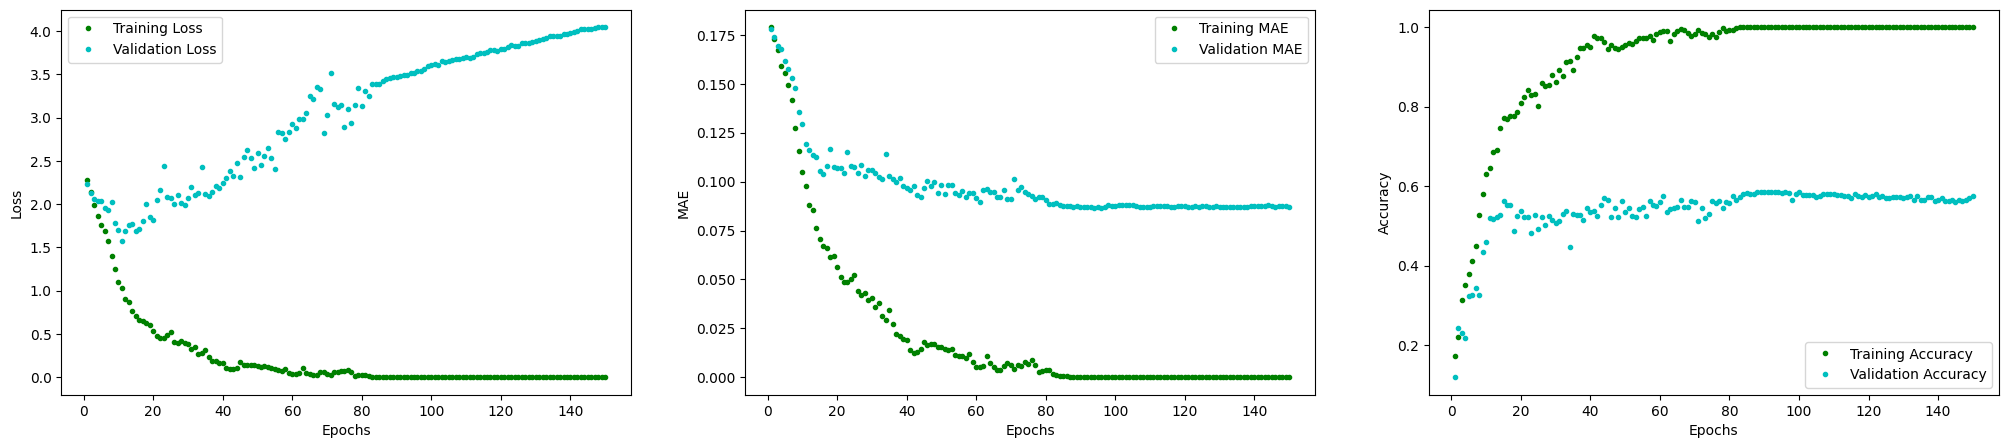

In [15]:
plot_history(lstm_stateless_history)

In [16]:
score = model_lstm_stateless.evaluate(x_test_rnn, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 4.040943145751953
Test accuracy: 0.574525773525238


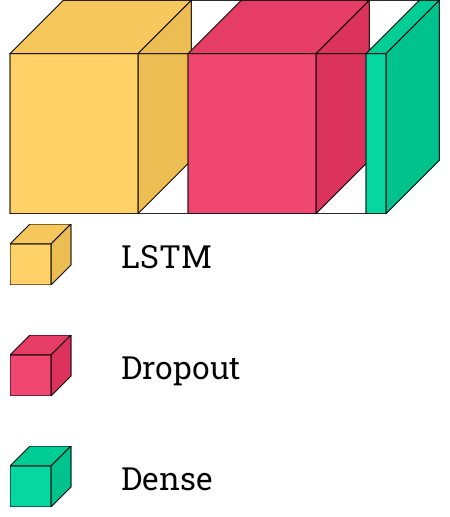

In [71]:
font = ImageFont.truetype("RobotoSlab-VariableFont_wght.ttf", 32)
visualkeras.layered_view(model_lstm_stateless, font=font, min_xy=160, scale_z=1, spacing=50, legend=True, to_file='output_figures/visual_lstm_stateless.png').show()

12/12 [==============================] - 0s 3ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fdcd8e3efa0>


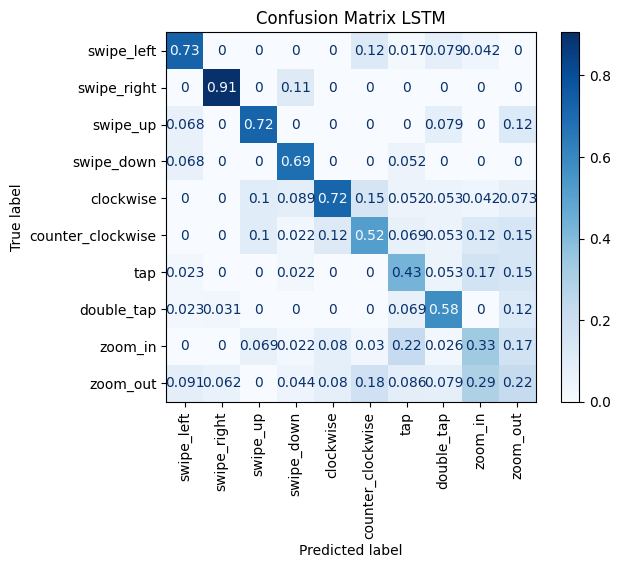

In [17]:
y_pred = model_lstm_stateless.predict(x_test_rnn)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_lstm.svg', bbox_inches="tight")

plt.show()

In [ ]:
print("================= Running on training data (Toy Example): =================")
for i in range(x_train_normalized.shape[0]):
    test_sample = np.expand_dims(x_train_normalized[i], -4)
    test_prediction = model_lstm_stateless.predict(test_sample)
    print("Prediction: %s, actual: %s" % (Gestures(np.argmax(test_prediction)), Gestures(np.argmax(y_train[i]))))

print("\n\n================= Running on testing data: =================")
for i in range(x_test_normalized.shape[0]):
    test_sample = np.expand_dims(x_test_normalized[i], -4)
    test_prediction = model_lstm_stateless.predict(test_sample)
    print("Prediction: %s, actual: %s" % (Gestures(np.argmax(test_prediction)), Gestures(np.argmax(y_test[i]))))

In [18]:
# K-Fold validation
model = build_lstm_stateless_model(128, 256, False, True, rnn_shape)
combined_reshaped_x = combined_x.reshape([-1] + rnn_shape)
(acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model, combined_reshaped_x, combined_y, num_folds=5)

Model: "LSTM_Stateless"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           73728     
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 flatten_4 (Flatten)         (None, 2560)              0         
                                                                 
 predictions (Dense)         (None, 10)                25610     
                                                                 
Total params: 99338 (388.04 KB)
Trainable params: 99338 (388.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


INFO:CSE3000:Fold No. 1


Epoch 1/200
31/31 - 1s - loss: 2.3017 - acc: 0.1291 - mae: 0.1793 - 1s/epoch - 45ms/step
Epoch 2/200
31/31 - 0s - loss: 2.1718 - acc: 0.2175 - mae: 0.1759 - 238ms/epoch - 8ms/step
Epoch 3/200
31/31 - 0s - loss: 2.0225 - acc: 0.2500 - mae: 0.1681 - 222ms/epoch - 7ms/step
Epoch 4/200
31/31 - 0s - loss: 1.9216 - acc: 0.3079 - mae: 0.1634 - 200ms/epoch - 6ms/step
Epoch 5/200
31/31 - 0s - loss: 1.8385 - acc: 0.3455 - mae: 0.1601 - 200ms/epoch - 6ms/step
Epoch 6/200
31/31 - 0s - loss: 1.7098 - acc: 0.4004 - mae: 0.1520 - 184ms/epoch - 6ms/step
Epoch 7/200
31/31 - 0s - loss: 1.5914 - acc: 0.4329 - mae: 0.1439 - 193ms/epoch - 6ms/step
Epoch 8/200
31/31 - 0s - loss: 1.4441 - acc: 0.5051 - mae: 0.1332 - 195ms/epoch - 6ms/step
Epoch 9/200
31/31 - 0s - loss: 1.2975 - acc: 0.5620 - mae: 0.1218 - 193ms/epoch - 6ms/step
Epoch 10/200
31/31 - 0s - loss: 1.2485 - acc: 0.5783 - mae: 0.1168 - 191ms/epoch - 6ms/step
Epoch 11/200
31/31 - 0s - loss: 1.1661 - acc: 0.5915 - mae: 0.1099 - 192ms/epoch - 6ms/step

INFO:CSE3000:Fold No. 2


Epoch 1/200
31/31 - 1s - loss: 2.2907 - acc: 0.1220 - mae: 0.1789 - 1s/epoch - 42ms/step
Epoch 2/200
31/31 - 0s - loss: 2.1965 - acc: 0.1992 - mae: 0.1768 - 233ms/epoch - 8ms/step
Epoch 3/200
31/31 - 0s - loss: 2.0383 - acc: 0.2785 - mae: 0.1695 - 217ms/epoch - 7ms/step
Epoch 4/200
31/31 - 0s - loss: 1.9140 - acc: 0.3120 - mae: 0.1633 - 202ms/epoch - 7ms/step
Epoch 5/200
31/31 - 0s - loss: 1.7682 - acc: 0.3567 - mae: 0.1557 - 213ms/epoch - 7ms/step
Epoch 6/200
31/31 - 0s - loss: 1.6652 - acc: 0.4096 - mae: 0.1490 - 213ms/epoch - 7ms/step
Epoch 7/200
31/31 - 0s - loss: 1.5274 - acc: 0.4736 - mae: 0.1392 - 210ms/epoch - 7ms/step
Epoch 8/200
31/31 - 0s - loss: 1.4557 - acc: 0.4817 - mae: 0.1325 - 203ms/epoch - 7ms/step
Epoch 9/200
31/31 - 0s - loss: 1.3128 - acc: 0.5447 - mae: 0.1236 - 206ms/epoch - 7ms/step
Epoch 10/200
31/31 - 0s - loss: 1.2137 - acc: 0.5894 - mae: 0.1139 - 211ms/epoch - 7ms/step
Epoch 11/200
31/31 - 0s - loss: 1.1010 - acc: 0.6209 - mae: 0.1085 - 210ms/epoch - 7ms/step

INFO:CSE3000:Fold No. 3


Epoch 1/200
31/31 - 1s - loss: 2.2862 - acc: 0.1392 - mae: 0.1788 - 1s/epoch - 45ms/step
Epoch 2/200
31/31 - 0s - loss: 2.1850 - acc: 0.1890 - mae: 0.1763 - 249ms/epoch - 8ms/step
Epoch 3/200
31/31 - 0s - loss: 2.0206 - acc: 0.2896 - mae: 0.1684 - 220ms/epoch - 7ms/step
Epoch 4/200
31/31 - 0s - loss: 1.8742 - acc: 0.3283 - mae: 0.1611 - 216ms/epoch - 7ms/step
Epoch 5/200
31/31 - 0s - loss: 1.7820 - acc: 0.3547 - mae: 0.1566 - 209ms/epoch - 7ms/step
Epoch 6/200
31/31 - 0s - loss: 1.6684 - acc: 0.4075 - mae: 0.1490 - 200ms/epoch - 6ms/step
Epoch 7/200
31/31 - 0s - loss: 1.6215 - acc: 0.4278 - mae: 0.1445 - 193ms/epoch - 6ms/step
Epoch 8/200
31/31 - 0s - loss: 1.5171 - acc: 0.4563 - mae: 0.1390 - 205ms/epoch - 7ms/step
Epoch 9/200
31/31 - 0s - loss: 1.3951 - acc: 0.5112 - mae: 0.1296 - 212ms/epoch - 7ms/step
Epoch 10/200
31/31 - 0s - loss: 1.3044 - acc: 0.5437 - mae: 0.1218 - 208ms/epoch - 7ms/step
Epoch 11/200
31/31 - 0s - loss: 1.1652 - acc: 0.6098 - mae: 0.1101 - 199ms/epoch - 6ms/step

INFO:CSE3000:Fold No. 4


Epoch 1/200
31/31 - 1s - loss: 2.2989 - acc: 0.1159 - mae: 0.1790 - 1s/epoch - 37ms/step
Epoch 2/200
31/31 - 0s - loss: 2.2204 - acc: 0.1961 - mae: 0.1775 - 255ms/epoch - 8ms/step
Epoch 3/200
31/31 - 0s - loss: 2.0433 - acc: 0.2856 - mae: 0.1701 - 234ms/epoch - 8ms/step
Epoch 4/200
31/31 - 0s - loss: 1.8390 - acc: 0.3496 - mae: 0.1585 - 232ms/epoch - 7ms/step
Epoch 5/200
31/31 - 0s - loss: 1.7653 - acc: 0.3862 - mae: 0.1546 - 231ms/epoch - 7ms/step
Epoch 6/200
31/31 - 0s - loss: 1.6594 - acc: 0.4157 - mae: 0.1469 - 221ms/epoch - 7ms/step
Epoch 7/200
31/31 - 0s - loss: 1.5108 - acc: 0.4807 - mae: 0.1375 - 219ms/epoch - 7ms/step
Epoch 8/200
31/31 - 0s - loss: 1.3752 - acc: 0.5356 - mae: 0.1278 - 211ms/epoch - 7ms/step
Epoch 9/200
31/31 - 0s - loss: 1.2387 - acc: 0.5843 - mae: 0.1162 - 216ms/epoch - 7ms/step
Epoch 10/200
31/31 - 0s - loss: 1.1426 - acc: 0.5925 - mae: 0.1095 - 217ms/epoch - 7ms/step
Epoch 11/200
31/31 - 0s - loss: 1.0375 - acc: 0.6443 - mae: 0.0993 - 193ms/epoch - 6ms/step

INFO:CSE3000:Fold No. 5


Epoch 1/200
31/31 - 1s - loss: 2.2806 - acc: 0.1514 - mae: 0.1787 - 1s/epoch - 41ms/step
Epoch 2/200
31/31 - 0s - loss: 2.1880 - acc: 0.1961 - mae: 0.1761 - 251ms/epoch - 8ms/step
Epoch 3/200
31/31 - 0s - loss: 2.0266 - acc: 0.2622 - mae: 0.1688 - 222ms/epoch - 7ms/step
Epoch 4/200
31/31 - 0s - loss: 1.9199 - acc: 0.2907 - mae: 0.1632 - 216ms/epoch - 7ms/step
Epoch 5/200
31/31 - 0s - loss: 1.7980 - acc: 0.3638 - mae: 0.1583 - 218ms/epoch - 7ms/step
Epoch 6/200
31/31 - 0s - loss: 1.7164 - acc: 0.3974 - mae: 0.1520 - 211ms/epoch - 7ms/step
Epoch 7/200
31/31 - 0s - loss: 1.5897 - acc: 0.4350 - mae: 0.1434 - 210ms/epoch - 7ms/step
Epoch 8/200
31/31 - 0s - loss: 1.5292 - acc: 0.4766 - mae: 0.1394 - 204ms/epoch - 7ms/step
Epoch 9/200
31/31 - 0s - loss: 1.3539 - acc: 0.5295 - mae: 0.1257 - 222ms/epoch - 7ms/step
Epoch 10/200
31/31 - 0s - loss: 1.2278 - acc: 0.5772 - mae: 0.1154 - 193ms/epoch - 6ms/step
Epoch 11/200
31/31 - 0s - loss: 1.1274 - acc: 0.6057 - mae: 0.1074 - 202ms/epoch - 7ms/step

In [19]:
print(acc_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

[82.92682766914368, 80.08130192756653, 76.01625919342041, 74.79674816131592, 78.86179089546204]
Acc: 78.537 std: 2.902
1.178848111629486


With A3 data: 75.370 std: 3.365
With A3 data (reshaped to (20, 15)): 79.422 std: 2.424

In [15]:
with tf.device(device_name=device):
    run_model = tf.function(lambda x: model_lstm_stateless(x))
    # This is important, let's fix the input size.
    BATCH_SIZE = 1
    STEPS = 20
    INPUT_SIZE = 15
    concrete_func = run_model.get_concrete_function(
        tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model_lstm_stateless.inputs[0].dtype))

    MODEL_DIR = "keras_lstm"
    model_lstm_stateless.save(MODEL_DIR, signatures=concrete_func)

INFO:tensorflow:Assets written to: keras_lstm/assets


INFO:tensorflow:Assets written to: keras_lstm/assets


In [18]:
with tf.device(device_name=device):
    # Convert to tflite model
    converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
    # converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm_stateless)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    tflite_model = converter.convert()
    open("lstm_model.tflite", "wb").write(tflite_model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.experimental_new_converter = True

    def representative_dataset_generator():
        for value in x_test_rnn:
            yield [np.array(value, dtype=np.float32, ndmin=3)]

    converter.representative_dataset = representative_dataset_generator
    tflite_model_quantized = converter.convert()

    open("lstm_model_quantized.tflite", "wb").write(tflite_model_quantized)

2023-05-24 17:28:08.579571: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-24 17:28:08.579618: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-24 17:28:08.579745: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: keras_lstm
2023-05-24 17:28:08.582897: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-05-24 17:28:08.582915: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: keras_lstm
2023-05-24 17:28:08.592154: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-05-24 17:28:08.641692: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: keras_lstm
2023-05-24 17:28:08.671804: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 92059 microseconds.
2023

In [19]:
model_size = os.path.getsize("lstm_model.tflite")
quantized_size = os.path.getsize("lstm_model_quantized.tflite")
print("Normal model size: %d bytes" % model_size)
print("Quantized model size: %d bytes" % quantized_size)
print("Difference: %d bytes" % (model_size - quantized_size))

Normal model size: 53432 bytes
Quantized model size: 17464 bytes
Difference: 35968 bytes


In [20]:
!xxd -i lstm_model_quantized.tflite > lstm_model_quantized.cc
!xxd -i lstm_model.tflite > lstm_model.cc

In [55]:
# TFLite model Interpreter
tflite_test = tf.lite.Interpreter('lstm_model_quantized.tflite')
tflite_test.allocate_tensors()
print(tflite_test.get_tensor_details())

input_index = tflite_test.get_input_details()[0]["index"]
output_index = tflite_test.get_output_details()[0]["index"]

predictions = []
for x_value in x_test_rnn:
    x_value_tensor = tf.convert_to_tensor([x_value], dtype=np.float32)
    tflite_test.set_tensor(input_index, x_value_tensor)

    tflite_test.invoke()

    predictions.append(tflite_test.get_tensor(output_index)[0])

for pred, act in zip(predictions, y_test):
    print("Predicted: %s, Actual: %s" % (Gestures(np.argmax(pred)), Gestures(np.argmax(act))))

[{'name': 'serving_default_x:0', 'index': 0, 'shape': array([ 1, 20, 15], dtype=int32), 'shape_signature': array([ 1, 20, 15], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'LSTM_Stateless/flatten/Const', 'index': 1, 'shape': array([2], dtype=int32), 'shape_signature': array([2], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'LSTM_Stateless/predictions/BiasAdd/ReadVariableOp', 'index': 2, 'shape': array([10], dtype=int32), 'shape_signature': array([10], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (8.586030162405223e-05, 0), 'quantization_parameters': {'scales': array([8.58603e-05], dtype

# Stateful model:

In [46]:
def build_lstm_stateful_model(lstm_units, dense_1_units, dropout):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model = keras.Sequential(name="LSTM_Stateful")

    # Subject to change as we split up the data in fragments:
    model.add(layers.Input(batch_shape=(25, 4, 3), name="sensor_image"))
    model.add(layers.LSTM(units=lstm_units, batch_input_shape=(25, 4), stateful=True, name="lstm"))

    # Extra
    if dropout:
        model.add(layers.Dropout(rate=0.25, name="dropout"))

    model.add(layers.Dense(units=dense_1_units, activation='relu', name="dense_1"))

    # Output stage
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    model.summary()
    return model

In [47]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"
print(x_train_normalized.shape)

stateful_reshaped_x = x_train_normalized.reshape((-1 ,25, 4, 3))
print(stateful_reshaped_x.shape)

with tf.device(device):
    model_lstm_stateful = build_lstm_stateful_model(128, 128, True)
    model_lstm_stateful.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

    start = time.perf_counter()
    # Do we need to reset the states inbetween?
    lstm_stateful_history = model_lstm_stateful.fit(stateful_reshaped_x, y_train, epochs=200, batch_size=8, shuffle=False, validation_data=(x_test_normalized, y_test))

    end = time.perf_counter()
    print("Training took: %0.1f seconds" % (end - start))

(801, 100, 3)
(801, 25, 4, 3)
Model: "LSTM_Stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (25, 128)                 67584     
                                                                 
 dropout (Dropout)           (25, 128)                 0         
                                                                 
 dense_1 (Dense)             (25, 128)                 16512     
                                                                 
 predictions (Dense)         (25, 10)                  1290      
                                                                 
Total params: 85,386
Trainable params: 85,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-23 08:58:27.098068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-23 08:58:27.099137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-23 08:58:27.100035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "LSTM_Stateful" is incompatible with the layer: expected shape=(None, 4, 3), found shape=(None, 25, 4, 3)


In [ ]:
plot_history(lstm_stateful_history)

In [165]:
score = model_lstm_stateful.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "LSTM_Stateful" is incompatible with the layer: expected shape=(None, 4, 3), found shape=(None, 100, 3)


In [ ]:
# KFold
# K-Fold validation
model = build_lstm_stateful_model(128, 128, False)

(acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model, combined_x, combined_y, num_folds=5)

In [ ]:
print(acc_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

7/7 [==============================] - 0s 15ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f0fbaf8a580>


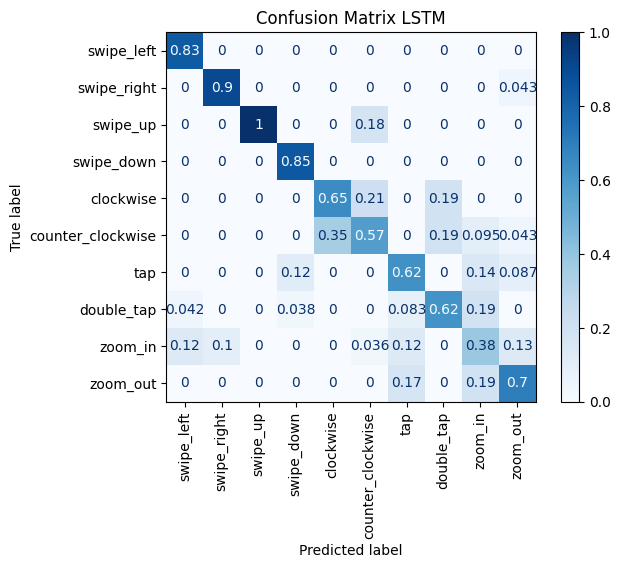

In [18]:
y_pred = model_lstm_stateful.predict(x_test_normalized)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_lstm.svg', bbox_inches="tight")

plt.show()

In [ ]:
visualkeras.layered_view(model_lstm_stateful, legend=True).show()

65


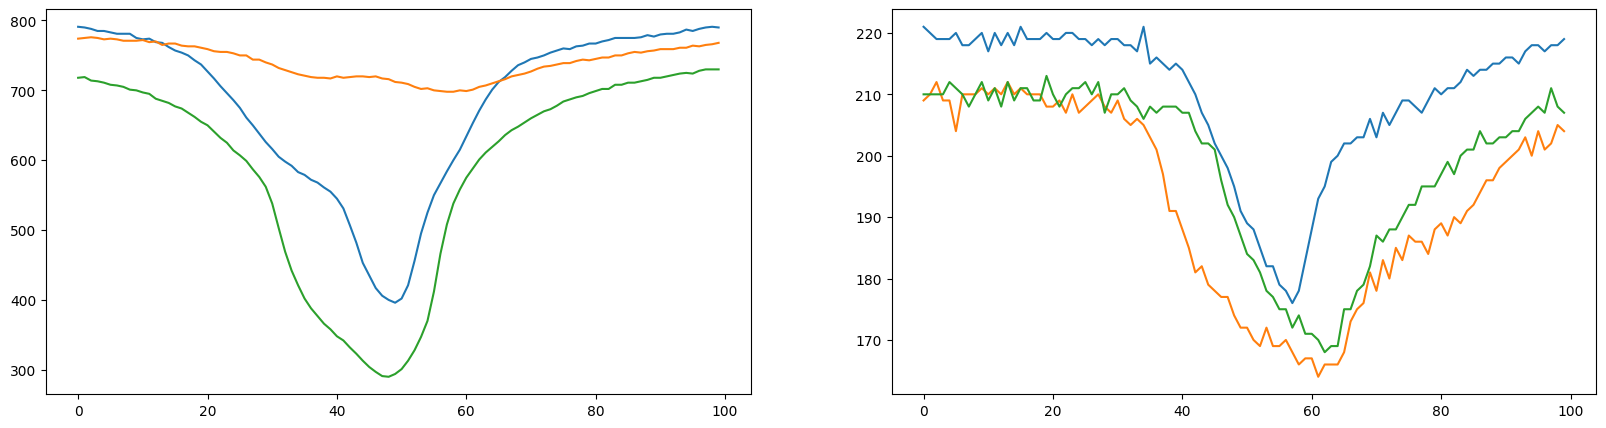

In [34]:
# taps = list(filter(lambda x: Gestures(x[1]) == Gestures.TAP, zip(x_train_normalized, y_train)))
# TODO: Remove the tap gesture that is noise
taps = load_gesture_samples(Gestures.TAP, Hand.right)
zooms = load_gesture_samples(Gestures.ZOOM_OUT, Hand.right)
print(len(taps))
random_tap = random.choice(taps)
random_zoom = random.choice(zooms)
# print(random_plot['candidate'])

# TODO: Maybe train a separate model for distinguishing the very confusion-heavy classes (Ensemble models)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(random_tap['data'])
axs[1].plot(random_zoom['data'])
plt.show()

Randomly selected gesture: 37
Candidate: E3


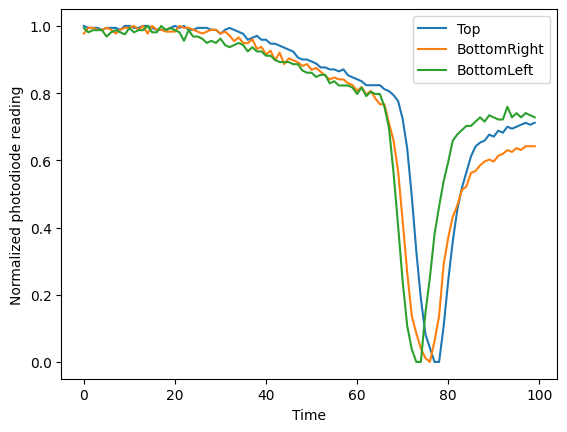

In [37]:
swipe_ups = load_gesture_samples(Gestures.SWIPE_UP, Hand.right)
random_select = random.randint(0, len(swipe_ups))
random_select = 37
print("Randomly selected gesture: %d" % random_select)
print("Candidate: %s" % swipe_ups[random_select]['candidate'])
selected_swipe_up = swipe_ups[random_select]['data']
scaler = MinMaxScaler((0, 1))
normalized_selected = scaler.fit_transform(selected_swipe_up)

plt.plot(normalized_selected)
plt.xlabel("Time")
plt.ylabel("Normalized photodiode reading")
plt.legend(['Top', 'BottomRight', 'BottomLeft'])
plt.savefig('output_figures/sample_graph.svg')
plt.show()

In [ ]:
print("\n\n================= Running on testing data: =================")
y_pred = model_lstm_stateful.predict(x_test_normalized)
for actual, pred in zip(y_test, y_pred):
    pred = Gestures(np.argmax(pred))
    actual = Gestures(np.argmax(actual))
    if pred == Gestures.SWIPE_RIGHT:
        print("Prediction: %s, actual: %s" % (pred, actual))

In [22]:
def build_gru_model(gru_units, dense_1_units, dense_1, dropout):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model = keras.Sequential(name="LSTM_Stateless")

    # Subject to change as we split up the data in fragments:
    # Stateless?
    model.add(layers.Input(shape=(100, 3), name="sensor_image"))
    model.add(layers.GRU(units=gru_units, name="gru"))
    # Stateful?
    # model_lstm_stateless.add(layers.Input(batch_shape=(100, 3, 1), name="sensor_image"))
    # model_lstm_stateless.add(layers.LSTM(units=128, stateful=True, name="lstm"))

    # Extra
    if dropout:
        model.add(layers.Dropout(rate=0.25, name="dropout"))

    if dense_1:
        model.add(layers.Dense(units=dense_1_units, activation='relu', name="dense_1"))

    # Output stage
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    model.summary()
    return model

In [24]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    start = time.perf_counter()
    # Do we need to reset the states inbetween?

    model_gru_stateless = build_gru_model(128, 256, True, True)
    model_gru_stateless.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

    gru_history = model_gru_stateless.fit(x_train_normalized, y_train, epochs=200, batch_size=16, shuffle=False, validation_data=(x_test_normalized, y_test))

    end = time.perf_counter()
    print("Training took %0.1f seconds" % (end - start))

Model: "LSTM_Stateless"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 predictions (Dense)         (None, 10)                2570      
                                                                 
Total params: 86,666
Trainable params: 86,666
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-22 19:28:47.640501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 19:28:47.642002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 19:28:47.642882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/39 [========================>.....] - ETA: 0s - loss: 2.3027 - acc: 0.1174 - mae: 0.1799

2023-05-22 19:28:49.658348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 19:28:49.659920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 19:28:49.661126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 21ms/step - loss: 2.3018 - acc: 0.1140 - mae: 0.1799 - val_loss: 2.2722 - val_acc: 0.1493 - val_mae: 0.1793
Epoch 2/200
39/39 [==============================] - 0s 12ms/step - loss: 2.2754 - acc: 0.1573 - mae: 0.1793 - val_loss: 2.2211 - val_acc: 0.1940 - val_mae: 0.1781
Epoch 3/200
39/39 [==============================] - 0s 10ms/step - loss: 2.1989 - acc: 0.1782 - mae: 0.1764 - val_loss: 2.0982 - val_acc: 0.1978 - val_mae: 0.1730
Epoch 4/200
39/39 [==============================] - 0s 10ms/step - loss: 2.1260 - acc: 0.1958 - mae: 0.1724 - val_loss: 2.0776 - val_acc: 0.2313 - val_mae: 0.1722
Epoch 5/200
39/39 [==============================] - 0s 11ms/step - loss: 2.1298 - acc: 0.2022 - mae: 0.1720 - val_loss: 2.0980 - val_acc: 0.2276 - val_mae: 0.1735
Epoch 6/200
39/39 [==============================] - 0s 10ms/step - loss: 2.0504 - acc: 0.2809 - mae: 0.1700 - val_loss: 2.0420 - val_acc: 0.2463 - val_mae: 0.1697
Epoch 7/200
39/39 [=========

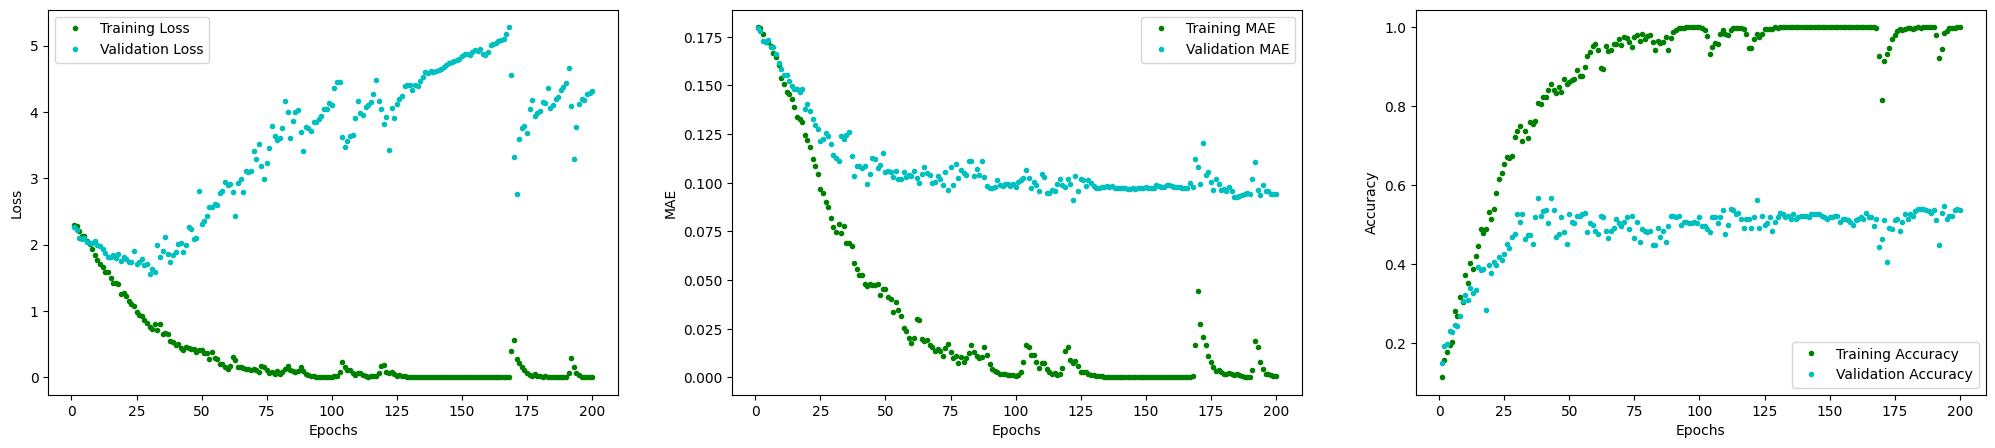

In [25]:
plot_history(gru_history)

In [26]:
score = model_gru_stateless.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 4.310211658477783
Test accuracy: 0.5373134613037109


9/9 [==============================] - 0s 8ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f4f36598f70>


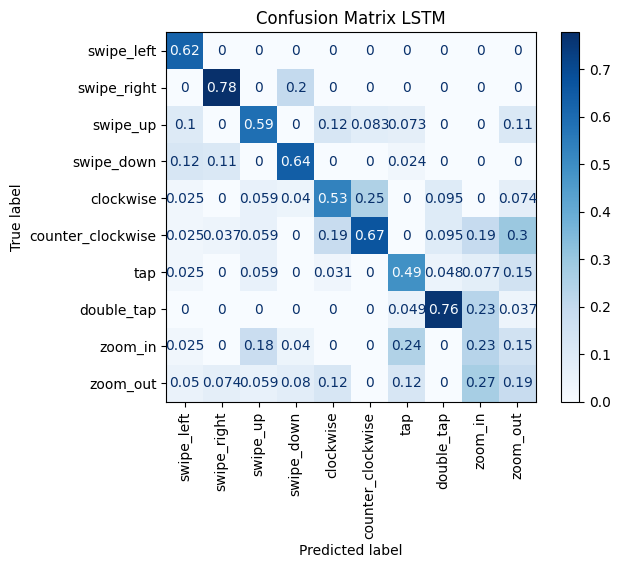

In [28]:
y_pred = model_gru_stateless.predict(x_test_normalized)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_gru.svg', bbox_inches="tight")

plt.show()

In [119]:
def build_simple_rnn_model(shape) -> keras.Model:
    model = keras.Sequential(name='Simple_RNN')

    model.add(layers.SimpleRNN(units=16, input_shape=shape, activation='linear'))
    model.add(layers.Dense(units=len(Gestures), activation='softmax'))

    return model

In [149]:
simple_rnn = build_simple_rnn_model(rnn_shape)
simple_rnn.compile(optimizer='adam', loss='mse', metrics=['acc', 'mae'])

simple_rnn_history = simple_rnn.fit(x_train_rnn, y_train, batch_size=16, epochs=400, validation_data=(x_test_rnn, y_test))

Epoch 1/400
42/42 [==============================] - 2s 19ms/step - loss: 0.1011 - acc: 0.0761 - mae: 0.1813 - val_loss: 0.0938 - val_acc: 0.1174 - val_mae: 0.1788
Epoch 2/400
42/42 [==============================] - 1s 17ms/step - loss: 0.0941 - acc: 0.1035 - mae: 0.1803 - val_loss: 0.0923 - val_acc: 0.1495 - val_mae: 0.1789
Epoch 3/400
42/42 [==============================] - 1s 16ms/step - loss: 0.0924 - acc: 0.1202 - mae: 0.1798 - val_loss: 0.0915 - val_acc: 0.1388 - val_mae: 0.1790
Epoch 4/400
42/42 [==============================] - 1s 17ms/step - loss: 0.0914 - acc: 0.1187 - mae: 0.1794 - val_loss: 0.0909 - val_acc: 0.1352 - val_mae: 0.1789
Epoch 5/400
42/42 [==============================] - 1s 16ms/step - loss: 0.0907 - acc: 0.1476 - mae: 0.1789 - val_loss: 0.0905 - val_acc: 0.1815 - val_mae: 0.1785
Epoch 6/400
42/42 [==============================] - 1s 17ms/step - loss: 0.0901 - acc: 0.1674 - mae: 0.1785 - val_loss: 0.0902 - val_acc: 0.1815 - val_mae: 0.1783
Epoch 7/400
42/4

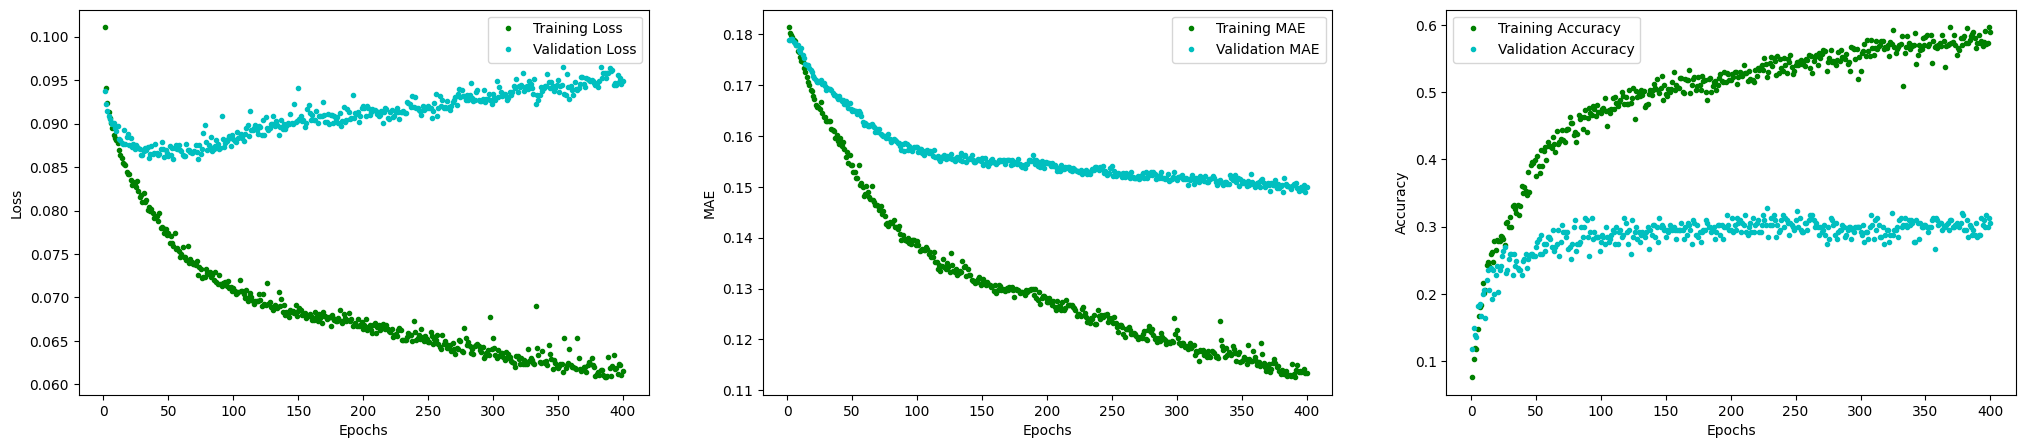

In [150]:
plot_history(simple_rnn_history)

In [151]:
score = simple_rnn.evaluate(x_test_rnn, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0948731079697609
Test accuracy: 0.30604982376098633
